# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [3]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.3.0


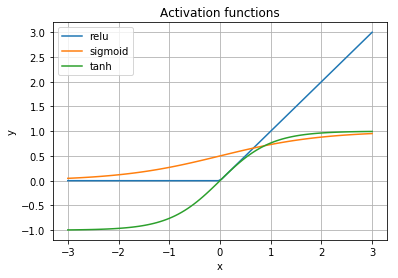

In [5]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [6]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [13]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    import os
    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    """ Load every batch of CIFAR-10 binary data """
    all_batches = []
    all_labels = []
    file_name_prifx = "data/cifar-10-batches-py"
    for b in range(1,6):
        f_train_curr = os.path.join(file_name_prifx, 'data_batch_%d' % (b, ))
        batch, labels = unpickle(f_train_curr)
        batch = batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        labels = np.array(labels)
        all_batches.append(batch)
        all_labels.append(labels)
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)  
    del batch, labels
    #X_train = np.array(all_batches[0:num_training])
    #Y_train = all_labels[0:num_training]
    #X_val = all_batches[num_training: num_training+num_validation]
    #Y_val = all_labels[num_training: num_training+num_validation]
    
    return data_train[0:num_training], labels_train[0:num_training], data_train[num_training: num_training+num_validation], labels_train[num_training: num_training+num_validation]
    #return X_train[0:num_training], Y_train, X_val, Y_val
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    import os
    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    file_name_prifx = "data/cifar-10-batches-py"
    f_test = os.path.join(file_name_prifx, 'test_batch')
    batch, labels = unpickle(f_test)
    data_test = batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels_test = np.array(labels)
    return data_test, labels_test    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()
print(X_test.shape)

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

(10000, 32, 32, 3)


## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [14]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1] # match to [batch, w, h, d] dimension
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]
    """
Computes a 2-D convolution given 4-D input and filter tensors.

Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:

Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels].
Extracts image patches from the input tensor to form a virtual tensor of shape [batch, out_height, out_width, filter_height * filter_width * in_channels].
For each patch, right-multiplies the filter matrix and the image patch vector.    
    """
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    # name, shape, dtype, init
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    # conv2d return A Tensor. Has the same type as input. A 4-D tensor
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def full_con(input, output_dim):
    # input shape = [batch_size, features_size]
    filter_shape = [input.get_shape()[1], output_dim]
    w_fc = tf.get_variable('w_fc', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b_fc = tf.get_variable('b_fc', [output_dim], initializer=tf.constant_initializer(0.0))
    return tf.matmul(input, w_fc) + b_fc
    
def batch_normalization(input, output_dim):
    axis = list(range(len(input.get_shape()) - 1))
    mean, variance = tf.nn.moments(input, axis) # count m, v except channel dim
    scale = tf.Variable(tf.ones([output_dim]))
    shift = tf.Variable(tf.zeros([output_dim]))
    epsilon = 0.001
    
    # reference https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/5-13-BN/
    ema = tf.train.ExponentialMovingAverage(decay=0.5)  # exponential moving average
    def mean_var_with_update():
        ema_apply_op = ema.apply([mean, variance])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(mean), tf.identity(variance)

    mean, var = mean_var_with_update()

    output = tf.nn.batch_normalization(input, mean, var, shift, scale, epsilon)    
    # output = tf.nn.batch_normalization(input, mean, variance, shift, scale, epsilon)
    return output
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [50]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self.learning_rate = 5e-4
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)      
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.pool2, [-1, 4096])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = full_con(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = full_con(self.relu3, 10)        
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        # is train or test?
        self.is_train = tf.placeholder(tf.bool)
        # dropout prob.
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(self.learning_rate, global_step,
                                           500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)       
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)     
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val, is_train=True, keep_prob=1.):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.is_train: is_train, self.keep_prob: keep_prob}              
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                #print(loss, accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d)' % step)
                    #print('iteration (%d): loss = %.3f, accuracy = %.3f' % (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            loss_hist_ = losses[1::100] # sparse the curve a bit
            plt.plot(loss_hist_, '-o')
            plt.xlabel('Iteration')
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Accuracy')
            plt.plot(accuracies, '-o', label='acc')
            plt.xlabel('Epoch')
            plt.legend(loc='lower right')
            plt.gcf().set_size_inches(15, 12)
            plt.show()  
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval, is_train=False, keep_prob=1.):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.is_train: is_train, self.keep_prob: keep_prob}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0)
iteration (50)
iteration (100)
iteration (150)
iteration (200)
iteration (250)
iteration (300)
iteration (350)


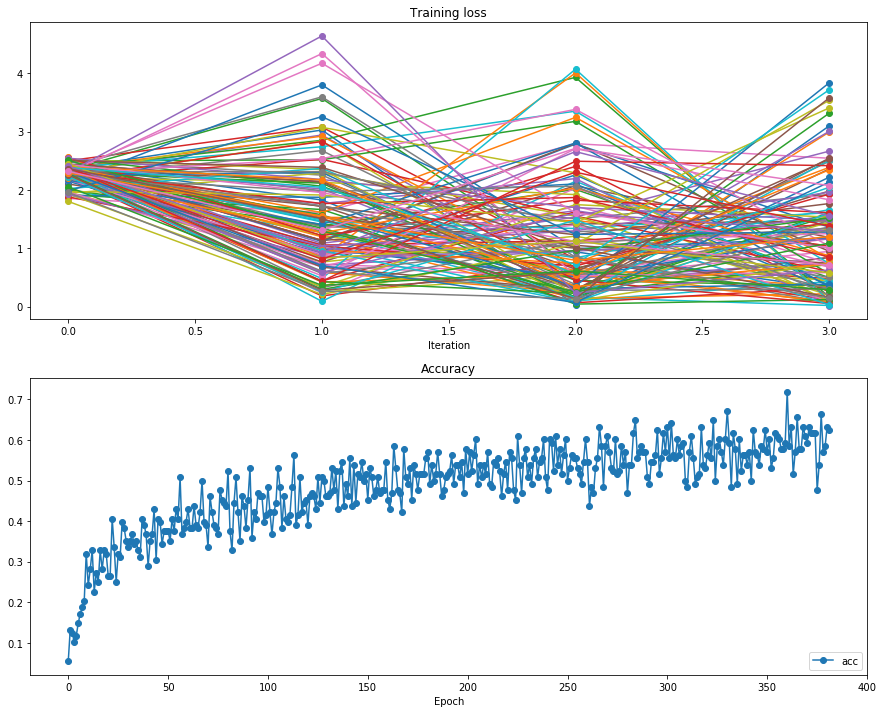

validation for epoch 0
-  epoch 0: validation accuracy = 0.610
train for epoch 1
iteration (400)
iteration (450)
iteration (500)
iteration (550)
iteration (600)
iteration (650)
iteration (700)
iteration (750)


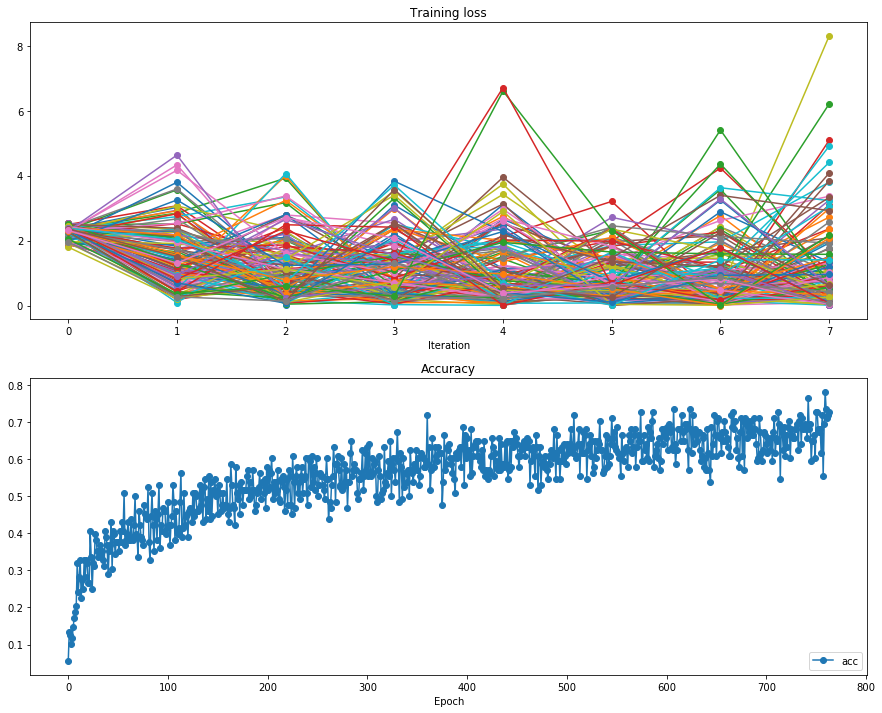

validation for epoch 1
-  epoch 1: validation accuracy = 0.663
train for epoch 2
iteration (800)
iteration (850)
iteration (900)
iteration (950)
iteration (1000)
iteration (1050)
iteration (1100)


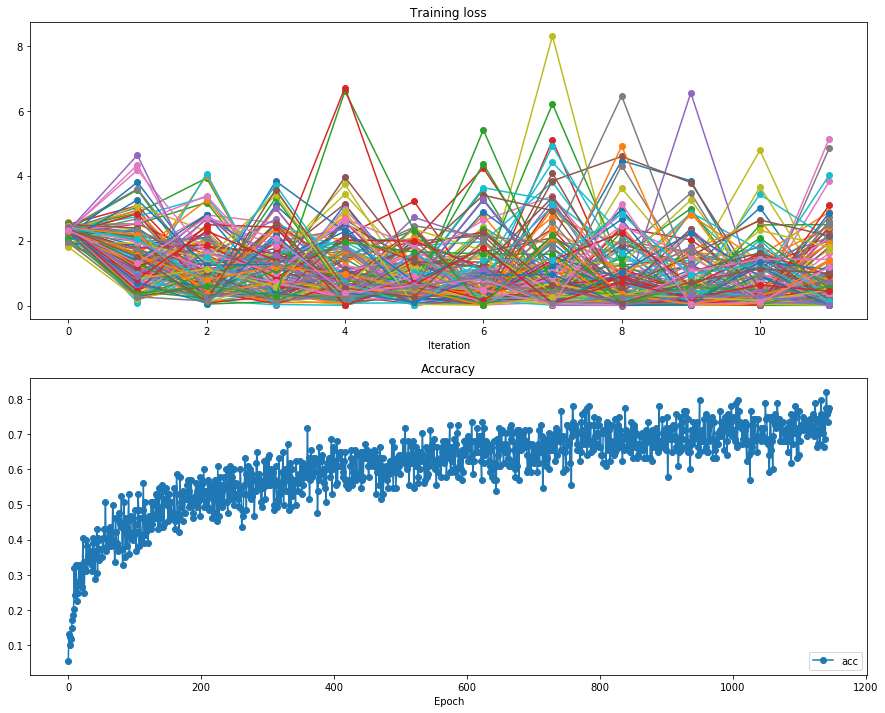

validation for epoch 2
-  epoch 2: validation accuracy = 0.692
train for epoch 3
iteration (1150)
iteration (1200)
iteration (1250)
iteration (1300)
iteration (1350)
iteration (1400)
iteration (1450)
iteration (1500)


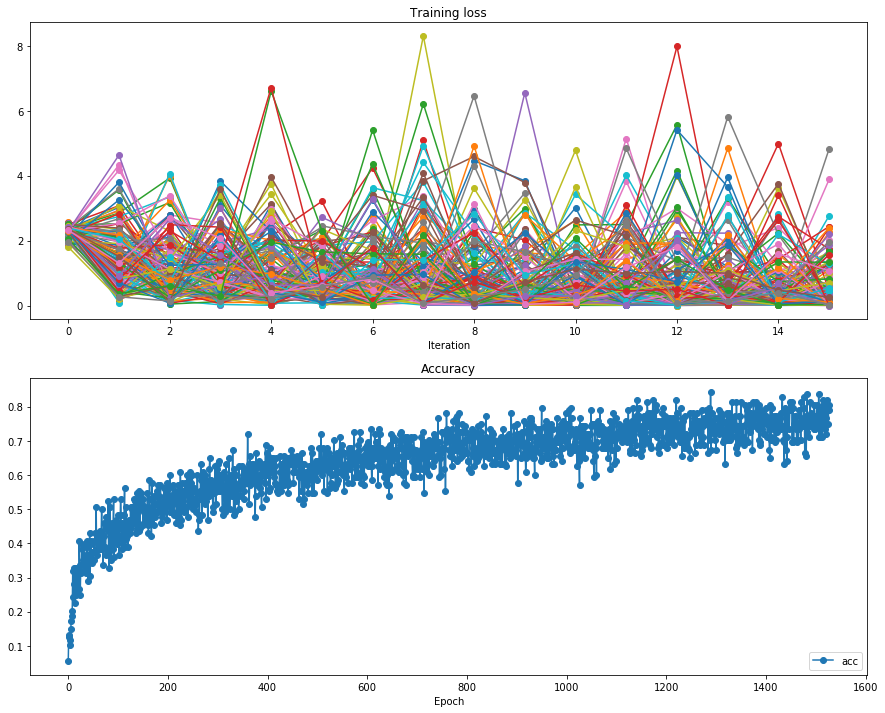

validation for epoch 3
-  epoch 3: validation accuracy = 0.702
train for epoch 4
iteration (1550)
iteration (1600)
iteration (1650)
iteration (1700)
iteration (1750)
iteration (1800)
iteration (1850)
iteration (1900)


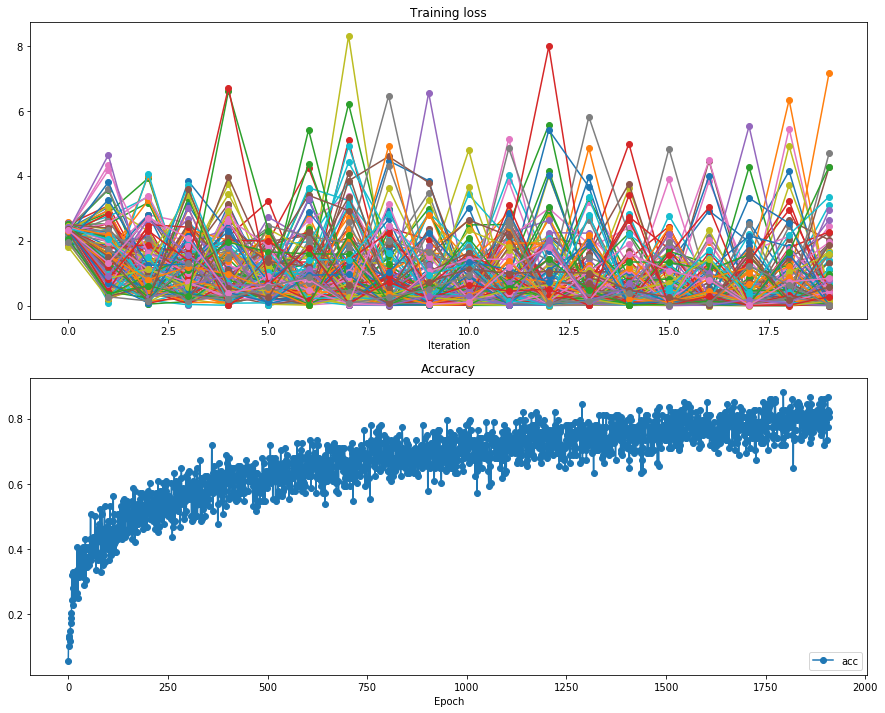

validation for epoch 4
-  epoch 4: validation accuracy = 0.702
***** test accuracy: 0.711
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [144]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [58]:
class YourModel(BaseModel):
    def __init__(self):
        self.local_isTrain = True
        super(YourModel, self).__init__()
        self.num_epoch = 10

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)
            self.norm1 = batch_normalization(self.pool1, 32)
            print('conv1 layer: ' + str(self.pool1.get_shape()))
            print('norm1 layer: ' + str(self.norm1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            self.norm2 = batch_normalization(self.pool2, 64)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))
            print('norm2 layer: ' + str(self.norm2.get_shape()))

        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.pool2, 5, 1, 64)
            self.relu3 = tf.nn.relu(self.conv3)
            self.norm3 = batch_normalization(self.relu3, 64)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv3 layer: ' + str(self.norm3.get_shape()))    

        with tf.variable_scope('conv4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv4 = conv2d(self.norm3, 3, 1, 64)
            self.relu4 = tf.nn.relu(self.conv4)
        with tf.variable_scope('conv5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################            
            self.conv5 = conv2d(self.relu4, 3, 1, 64)
            self.relu5 = tf.nn.relu(self.conv5)      
            
        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.relu5, [-1, 4096])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = full_con(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            # dropout layer
            if self.local_isTrain:
                self.relu3 = tf.nn.dropout(self.relu3, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = full_con(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################
    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(self.learning_rate, global_step,
                                           500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def evaluate(self, sess, X_eval, Y_eval, is_train=False, keep_prob=1.):
        eval_accuracy = 0.0
        eval_iter = 0
        self.local_isTrain = is_train
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.is_train: is_train, self.keep_prob: keep_prob}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
norm1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
norm2 layer: (?, 8, 8, 64)
conv3 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0)
iteration (50)
iteration (100)
iteration (150)
iteration (200)
iteration (250)
iteration (300)
iteration (350)


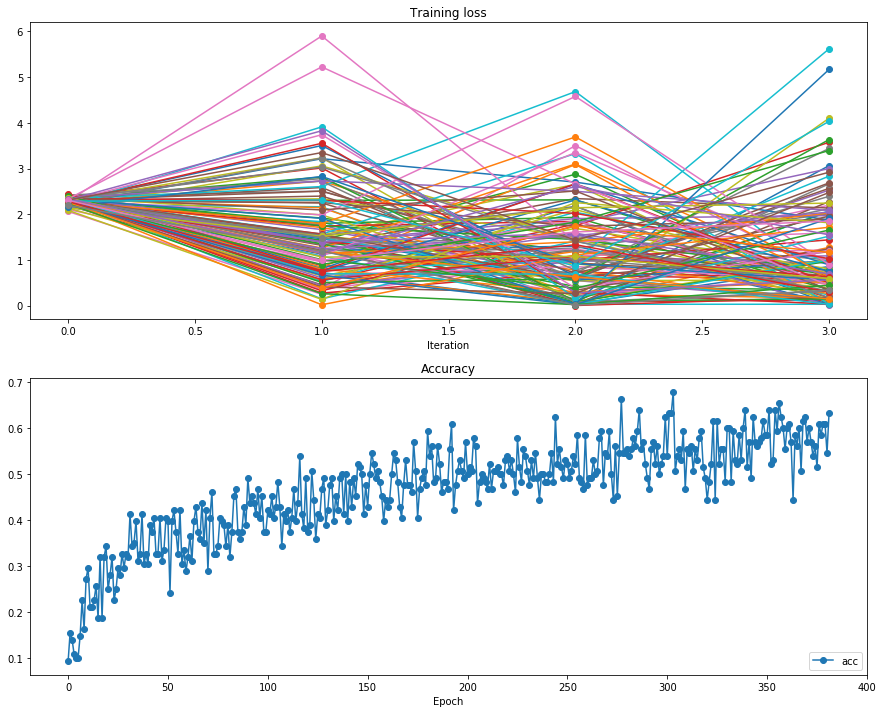

validation for epoch 0
-  epoch 0: validation accuracy = 0.616
train for epoch 1
iteration (400)
iteration (450)
iteration (500)
iteration (550)
iteration (600)
iteration (650)
iteration (700)
iteration (750)


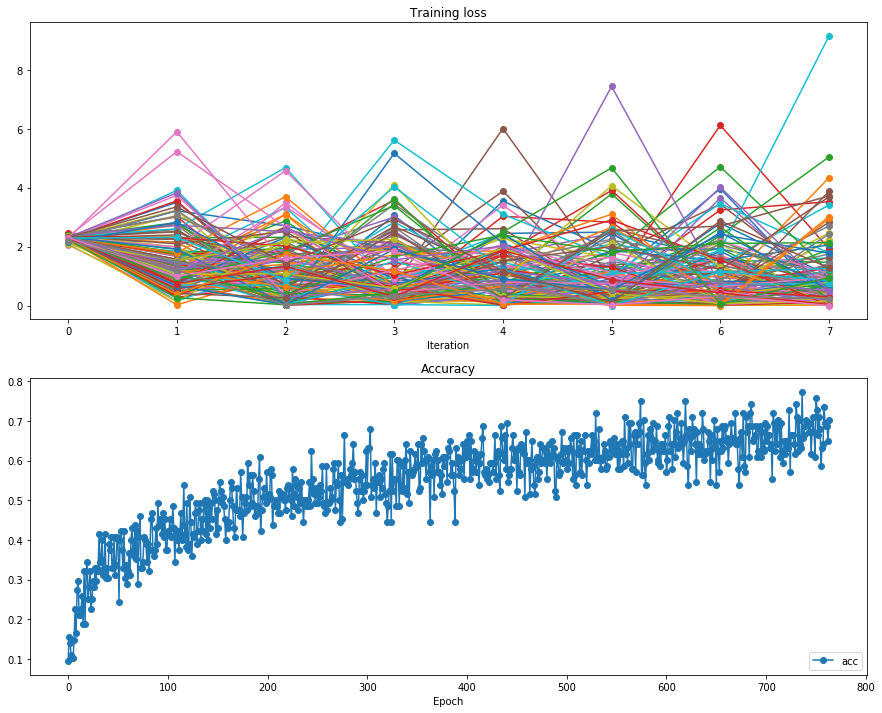

validation for epoch 1
-  epoch 1: validation accuracy = 0.691
train for epoch 2
iteration (800)
iteration (850)
iteration (900)
iteration (950)
iteration (1000)
iteration (1050)
iteration (1100)


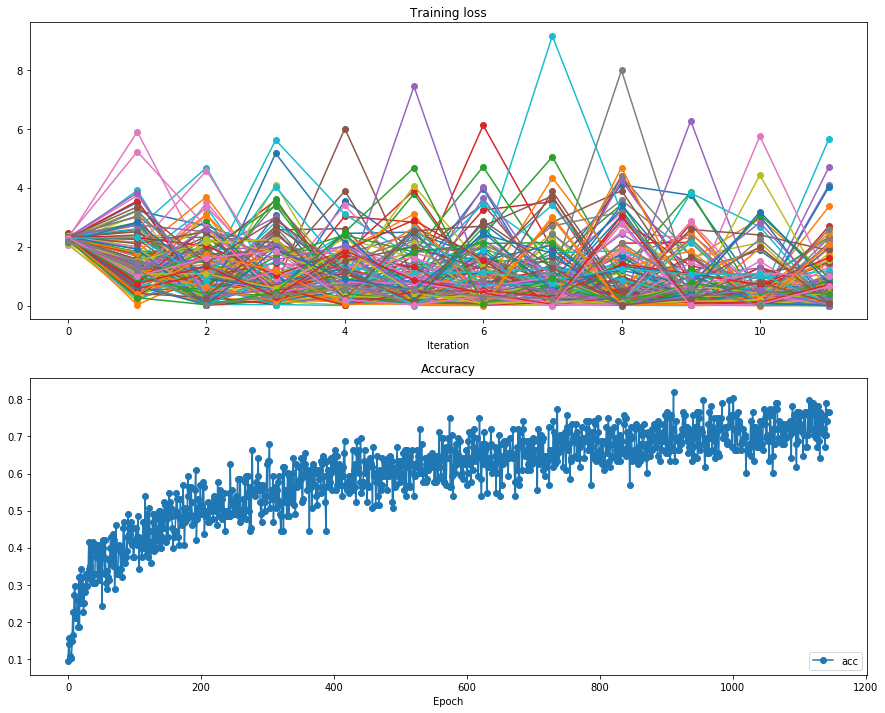

validation for epoch 2
-  epoch 2: validation accuracy = 0.721
train for epoch 3
iteration (1150)
iteration (1200)
iteration (1250)
iteration (1300)
iteration (1350)
iteration (1400)
iteration (1450)
iteration (1500)


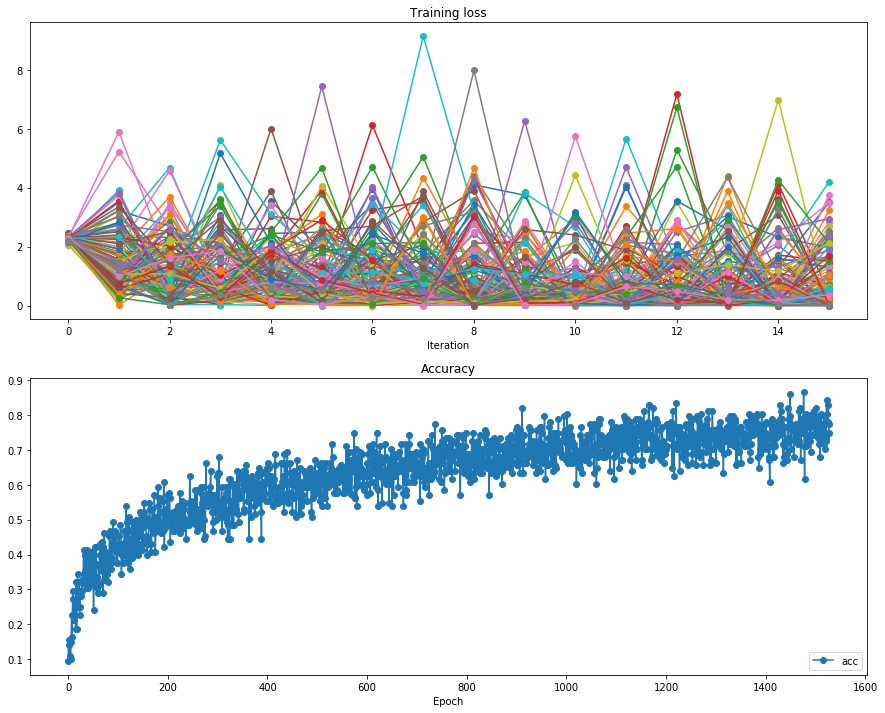

validation for epoch 3
-  epoch 3: validation accuracy = 0.743
train for epoch 4
iteration (1550)
iteration (1600)
iteration (1650)
iteration (1700)
iteration (1750)
iteration (1800)
iteration (1850)
iteration (1900)


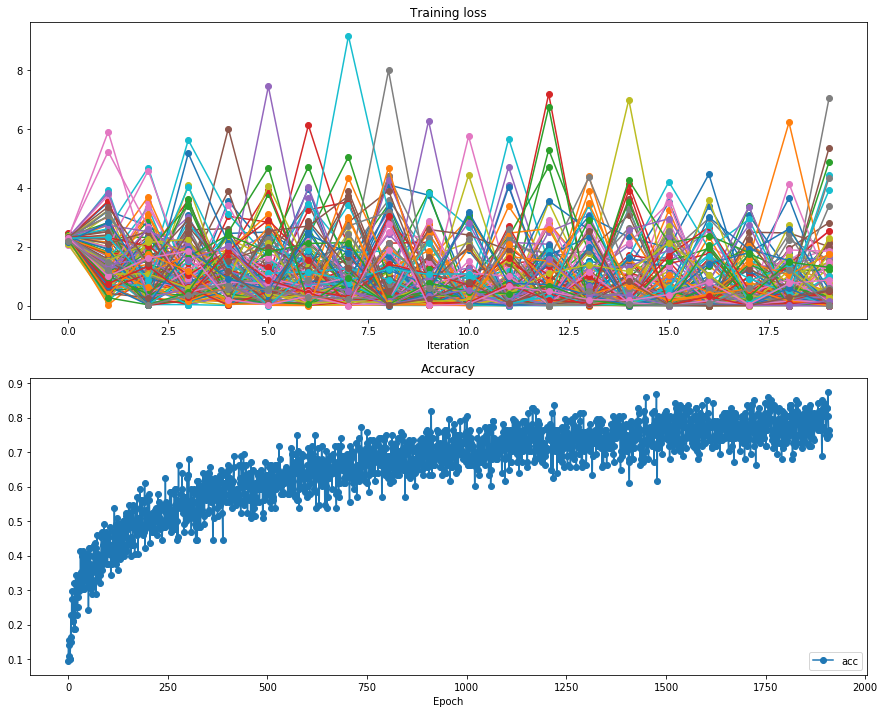

validation for epoch 4
-  epoch 4: validation accuracy = 0.760
train for epoch 5
iteration (1950)
iteration (2000)
iteration (2050)
iteration (2100)
iteration (2150)
iteration (2200)
iteration (2250)


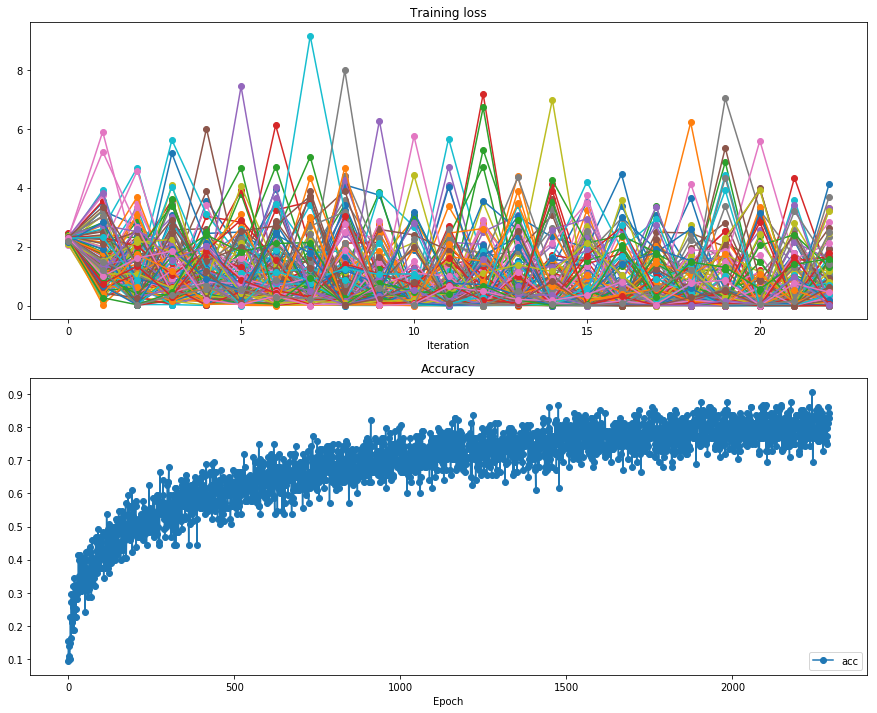

validation for epoch 5
-  epoch 5: validation accuracy = 0.758
train for epoch 6
iteration (2300)
iteration (2350)
iteration (2400)
iteration (2450)
iteration (2500)
iteration (2550)
iteration (2600)
iteration (2650)


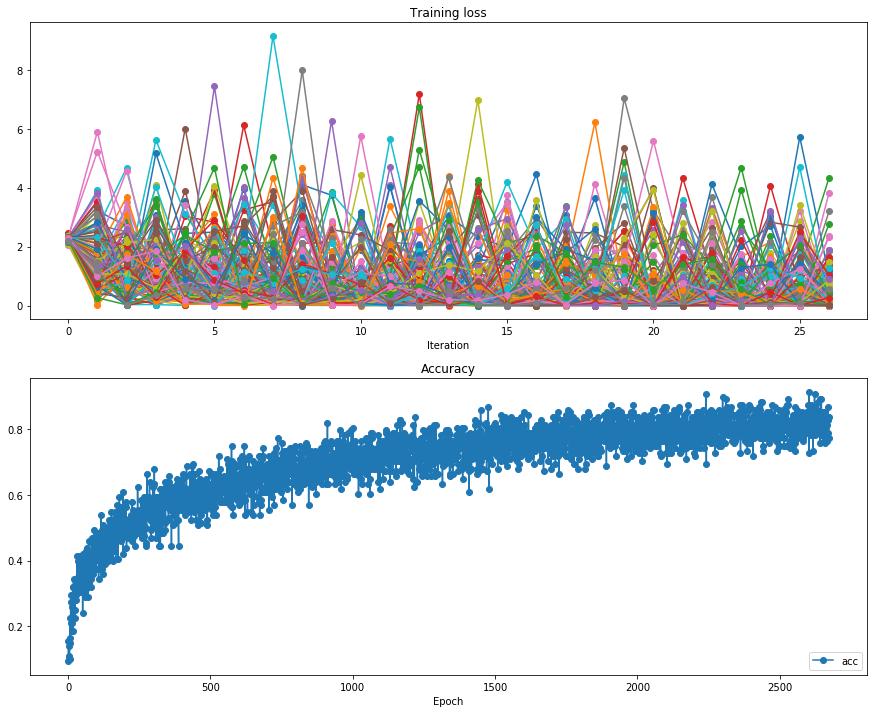

validation for epoch 6
-  epoch 6: validation accuracy = 0.770
train for epoch 7
iteration (2700)
iteration (2750)
iteration (2800)
iteration (2850)
iteration (2900)
iteration (2950)
iteration (3000)
iteration (3050)


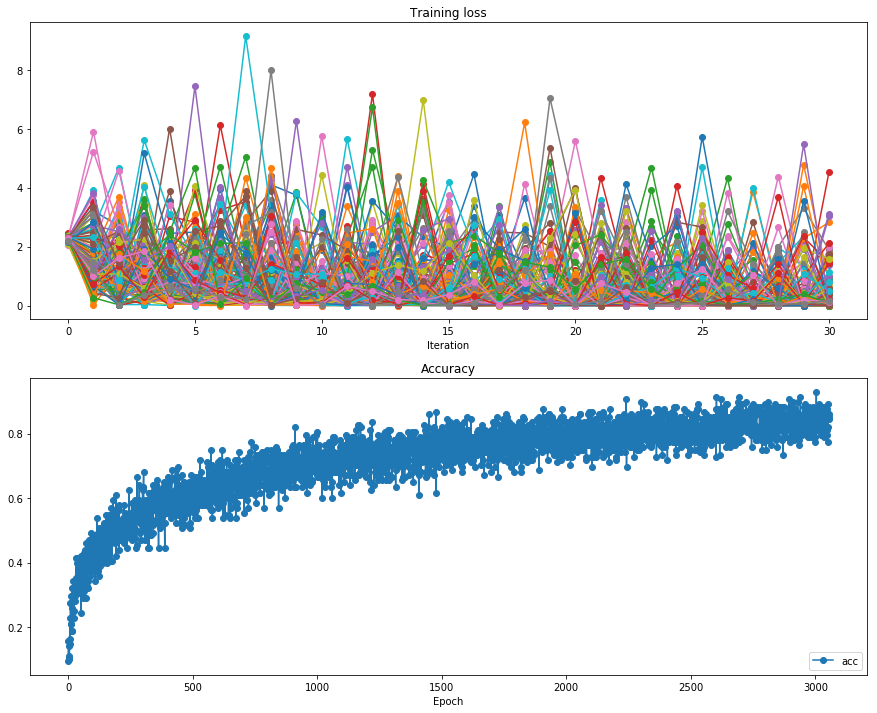

validation for epoch 7
-  epoch 7: validation accuracy = 0.766
train for epoch 8
iteration (3100)
iteration (3150)
iteration (3200)
iteration (3250)
iteration (3300)
iteration (3350)
iteration (3400)


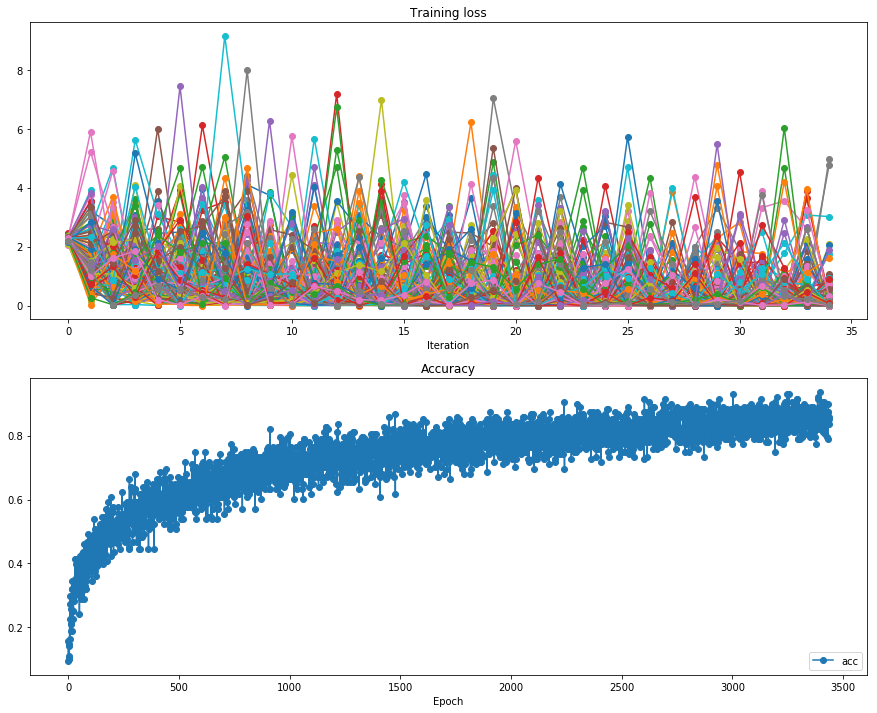

validation for epoch 8
-  epoch 8: validation accuracy = 0.754
train for epoch 9
iteration (3450)
iteration (3500)
iteration (3550)
iteration (3600)
iteration (3650)
iteration (3700)
iteration (3750)
iteration (3800)


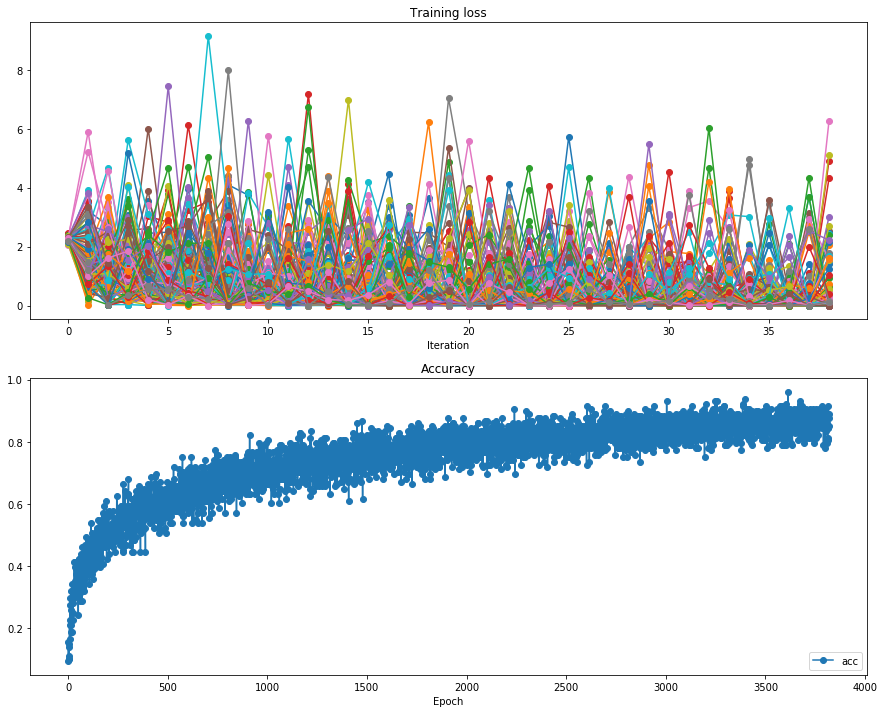

validation for epoch 9
-  epoch 9: validation accuracy = 0.775
***** test accuracy: 0.751
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [59]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
# Mean subtraction & Normalization
X_train_ = X_train
X_val_ = X_val
X_test_ = X_test

X_train -= np.mean(X_train, axis = 0)
X_train_ /= np.std(X_train, axis = 0)
X_val -= np.mean(X_val, axis = 0)
X_val_ /= np.std(X_val, axis = 0)
X_test -= np.mean(X_test, axis = 0)
X_test_ /= np.std(X_test, axis = 0)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val, keep_prob = 0.5)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [60]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
norm1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
norm2 layer: (?, 8, 8, 64)
conv3 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


In [51]:
"""
Conclusion:
My model try to proprocess input data via reduce_mean/normalization,
and also do batch-normalization after 3 conv layers.
the optimizer is also use the learning rate decay

the result is around 73% accuracy vs. base model 65%
update: my second trial about base model, added learning rate decay, 
        the accuracy enhanced from 65% to 71%
        my second trial about my model, added dropout layer with prob 0.5 after first full connected layer,
        the accuracy enhanced from 73% to 75%

the new result is my model 75% vs base model 71%
"""

'\nConclusion:\nMy model try to proprocess input data via reduce_mean/normalization,\nand also do batch-normalization after 3 conv layers.\nthe optimizer is also use the learning rate decay\n\nthe result is around 73% accuracy vs. base model 65%\nupdate: my second trial about base model, added learning rate decay, \n        the accuracy enhanced from 65% to 71%\n        my second trial about my model, added dropout layer with prob 0.5 after first full connected layer,\n        the accuracy enhanced from 73% to 75%\n\nthe new result is my model 75% vs base model 71%\n'